In [1]:
# !pip uninstall tensorflow-gpu -y
# !pip uninstall tensorflow -y
# !pip install tensorflow-gpu==2.0.0-rc0

In [2]:
import cudf as cd
import cupy as cp
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner import HyperParameters
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import xgboost as xgb
import cv2
import os

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  if __name__ == '__main__':


In [3]:
!nvidia-smi

Fri May 13 20:19:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
diseases = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy',

            'Potato___Early_blight', 'Potato___Late_blight',
            'Potato___healthy', 'Tomato_Bacterial_spot',
            'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold',
            'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite',
            'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus',
            'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']

In [5]:
def load_disease_images(disease_name):
    return os.listdir('../input/plantdisease/PlantVillage/' + disease_name + '/')

In [6]:
import tensorflow
tensorflow.test.is_built_with_cuda()

True

In [7]:
from tensorflow.keras.preprocessing import image
def load_image(path):
    return image.load_img(path, target_size = (64, 64))

In [8]:
images = os.listdir('../input/plantdisease/PlantVillage/' + str(diseases[0]) + '/')
images[:5]

['0f72db9c-d635-4415-9781-68937328aed2___NREC_B.Spot 9188.JPG',
 '1b8d3e98-43d9-441d-93ef-a359e6e9ddc2___NREC_B.Spot 9052.JPG',
 'b6d35d21-4812-4e32-ab9a-b6ddda8cbb79___JR_B.Spot 8972.JPG',
 'e4e7e5a2-5aa1-4378-833d-9142358c7c9b___JR_B.Spot 9092.JPG',
 '8b50f2db-cbf2-4758-bea6-a011f0cc1497___JR_B.Spot 3235.JPG']

In [9]:
def disease_image_set(d_names, disease):
    s = []
    labels = []
    for j in d_names[:500]:
        path = '../input/plantdisease/PlantVillage/' + disease + '/' + j
        disease_image = image.img_to_array(load_image(path))
        labels.append(disease)
        s.append(disease_image)
    return s, labels

In [10]:
data = []
labels = []
for i in diseases:
    disease_images_names = load_disease_images(i)
    a, b = disease_image_set(disease_images_names, i)
    data = data + a
    labels = labels + b
data = np.array(data)
labels = np.array(labels)    
data = data / 255.0

In [11]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(labels)
labels = encoder.transform(labels)
labels = keras.utils.to_categorical(labels)

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.3, random_state = 42)

In [13]:
from kerastuner.tuners import RandomSearch
from kerastuner import HyperParameters

In [14]:
def call_existing_code(layer_dropoutRate, layer_filter, layer_neurons):
    model = Sequential()
    model.add(Conv2D(layer_filter[0], (3, 3), activation = 'relu', padding = "same", input_shape = (64, 64, 3)))
    model.add(MaxPooling2D(pool_size = (3, 3)))
    model.add(Dropout(layer_dropoutRate[0]))
    model.add(Conv2D(layer_filter[1], (3, 3), activation = 'relu', padding = "same"))
    model.add(Conv2D(layer_filter[1], (3, 3), activation = 'relu', padding = "same"))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(layer_dropoutRate[1]))
    model.add(Conv2D(layer_filter[2], (3, 3), activation = 'relu', padding = "same"))
    model.add(Conv2D(layer_filter[2], (3, 3), activation = 'relu', padding = "same"))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(layer_dropoutRate[2]))
    model.add(Flatten())
    model.add(Dense(layer_neurons, activation = 'relu', ))
    model.add(Dropout(layer_dropoutRate[3]))
    model.add(Dense(15, activation = 'softmax'))
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', 
                 metrics = ['accuracy'])
    return model

In [15]:
def build_model(hp):
    layer_filter = []
    layer_dropoutRate = []
    for i in range(3):
        filters_list = []
        for j in range(7,12):
            filters_list.append(j)
        value = hp.Choice('lf' + str(i), filters_list)
        layer_filter.append(value)
    for i in range(4):
        value = hp.Float('dr' + str(i), min_value = 0.15, max_value = 0.9, step = 0.15)
        layer_dropoutRate.append(value)
    layer_neurons = hp.Choice('neurons', [256, 512, 1024, 2048])
    return call_existing_code(layer_dropoutRate, layer_filter, layer_neurons)

In [16]:
tuner = RandomSearch(
    build_model, 
    objective = 'val_loss',
    max_trials = 11,
    directory= 'dir'
)

2022-05-13 20:19:41.734076: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 20:19:41.738889: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 20:19:41.739812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 20:19:41.741112: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [17]:
tuner.search(x_train, y_train, epochs = 50, validation_data = (x_test, y_test))

Trial 11 Complete [00h 00m 56s]
val_loss: 2.697777032852173

Best val_loss So Far: 0.5972017645835876
Total elapsed time: 00h 12m 40s


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 10)        280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 10)        0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 8)         728       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 8)         0

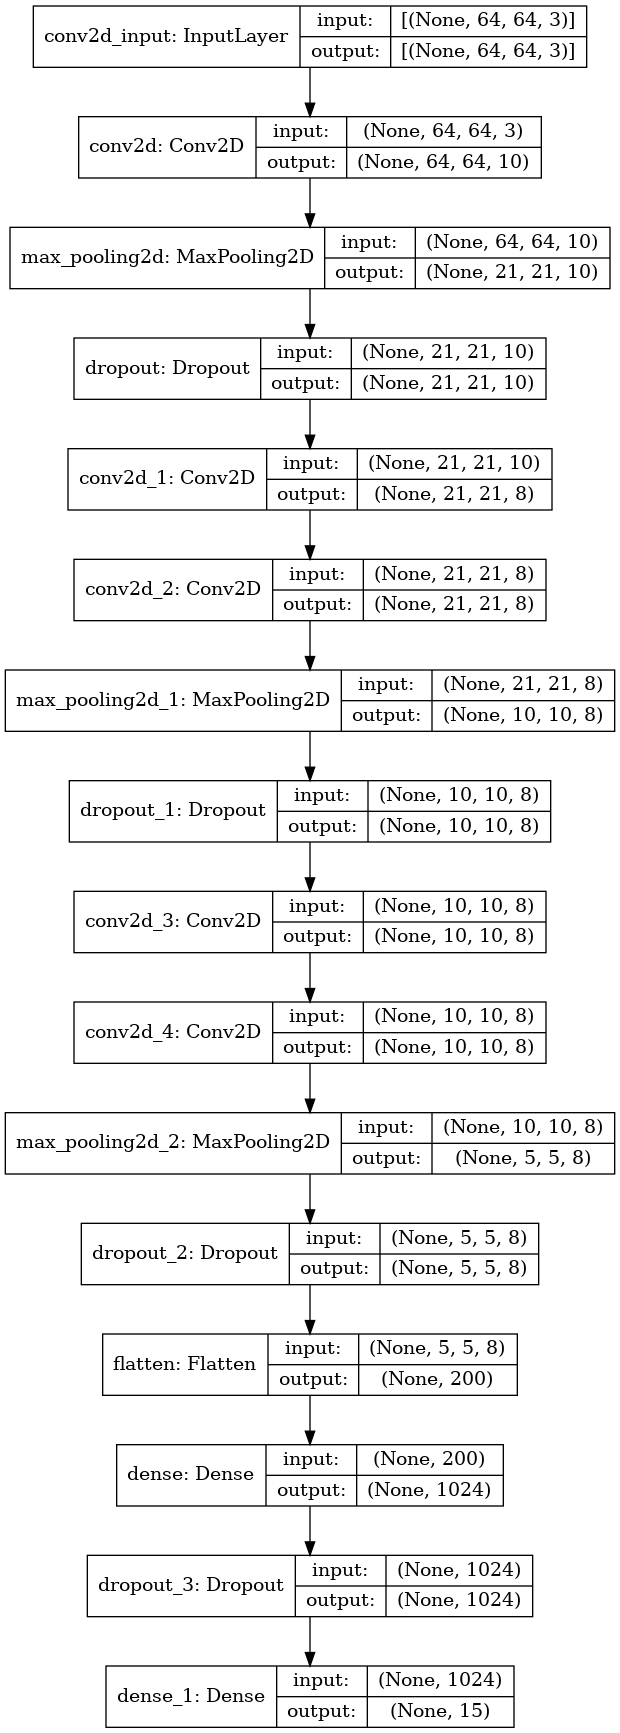

In [18]:
model = tuner.get_best_models()[0]
model.summary()
plot_model(model, to_file = 'cnn_model_plot.png', show_shapes = True, show_layer_names = True)

In [19]:
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True)
datagen.fit(x_train)

In [20]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
         validation_data = datagen.flow(x_test, y_test,
         batch_size = 8),
         epochs = 50)

Epoch 1/50
77/77 [==============================] - 11s 131ms/step - loss: 0.7360 - accuracy: 0.7503 - val_loss: 0.7124 - val_accuracy: 0.7623
Epoch 2/50
77/77 [==============================] - 10s 128ms/step - loss: 0.6564 - accuracy: 0.7828 - val_loss: 0.8645 - val_accuracy: 0.7111
Epoch 3/50
77/77 [==============================] - 9s 120ms/step - loss: 0.6230 - accuracy: 0.7879 - val_loss: 0.7249 - val_accuracy: 0.7528
Epoch 4/50
77/77 [==============================] - 9s 124ms/step - loss: 0.6069 - accuracy: 0.7899 - val_loss: 0.7179 - val_accuracy: 0.7642
Epoch 5/50
77/77 [==============================] - 9s 121ms/step - loss: 0.5814 - accuracy: 0.8011 - val_loss: 0.6328 - val_accuracy: 0.7955
Epoch 6/50
77/77 [==============================] - 10s 131ms/step - loss: 0.6007 - accuracy: 0.7993 - val_loss: 0.7083 - val_accuracy: 0.7647
Epoch 7/50
77/77 [==============================] - 10s 125ms/step - loss: 0.5801 - accuracy: 0.8037 - val_loss: 0.6535 - val_accuracy: 0.7908
Ep

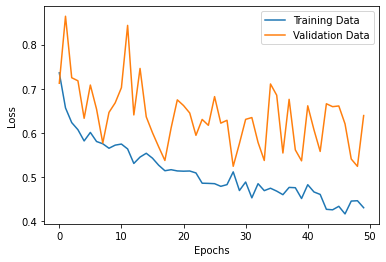

In [22]:
plt.plot(history.history['loss'], label = 'Training Data')
plt.plot(history.history['val_loss'], label = 'Validation Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

***Applying XgBoost for Image Classification***

In [14]:
import xgboost as xgb

In [15]:
x_train = x_train.reshape(x_train.shape[0], -1)
classifier = xgb.XGBClassifier(tree_method = 'gpu_hist', 
                                  predictor = 'gpu_predictor')
model = classifier.fit(x_train, y_train)

In [16]:
x_test = x_test.reshape(x_test.shape[0], -1)
y_pred = model.predict(x_test)

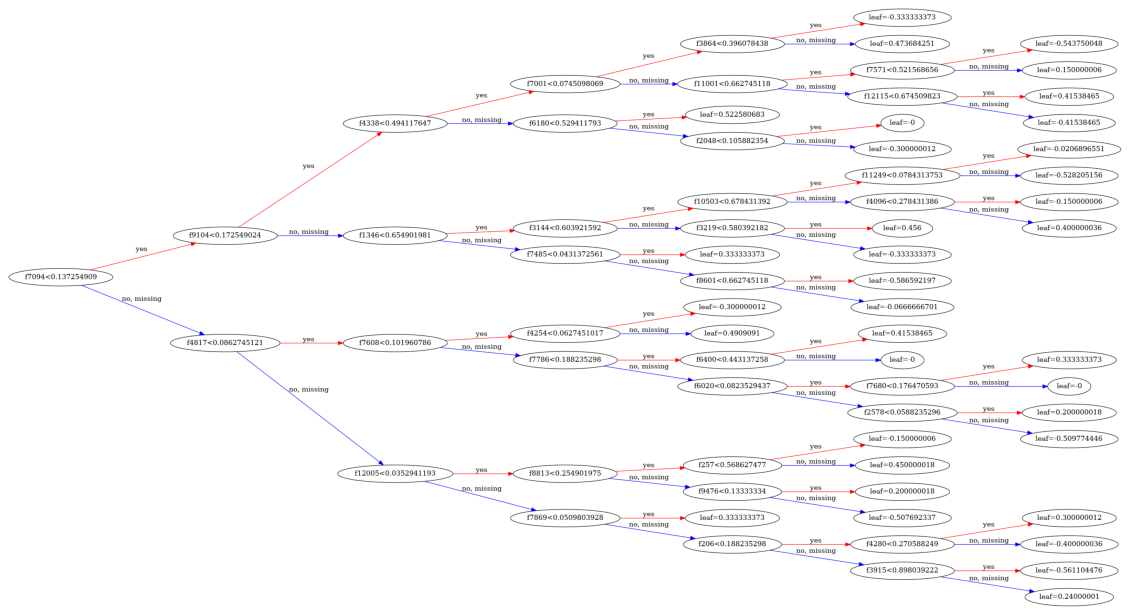

In [25]:
xgb.plot_tree(model, num_trees = 0, rankdir = 'LR', to_file = 'xgboost.png')
fig = plt.gcf()
fig.set_size_inches(20, 20)

In [ ]:
from cuml import metrics
print('Xgboost Accuracy: ', metrics.accuracy_score(y_test, y_pred))

***Using VGG16 for feature extraction and then applying XgBoost***

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
vgg_model = VGG16(input_shape = (64, 64, 3), weights = 'imagenet', include_top = False)
for layers in vgg_model.layers:
    layers.trainable = False

In [ ]:
vgg_model.summary()

In [ ]:
x_train = vgg_model.predict(x_train)
x_train = x_train.reshape(x_train.shape[0], -1)

In [ ]:
classifier = xgb.XGBClassifier(tree_method = 'gpu_hist', 
                                  predictor = 'gpu_predictor')
model = classifier.fit(x_train, y_train)

In [ ]:
ax = xgb.plot_importance(classifier, height = .8)
ax.grid(False)
ax.set_title('F score by feature')
plt.show()

In [ ]:
x_test = vgg_model.predict(x_test)
x_test = x_test.reshape(x_test.shape[0], -1)

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
from cuml import metrics
print('Xgboost Accuracy: ', metrics.accuracy_score(y_test, y_pred))

In [ ]:
y_test = cp.asarray(y_test)
x_test = cp.asarray(x_test)
y_train = cp.asarray(y_train)
x_train = cp.asarray(x_train)

In [ ]:
x_test.shape, x_train.shape

****Applying KNN****

In [ ]:
from cuml.neighbors import KNeighborsClassifier 
cuda_knn_model = KNeighborsClassifier(n_neighbors = 100)
cuda_knn_model.fit(x_train, y_train)
y_prediction = cuda_knn_model.predict(x_test)

In [ ]:
from cuml import metrics
print('KNeighborsClassifier Accuracy: ', metrics.accuracy_score(y_test, y_prediction))